In [1]:
import torch
import torch as t
import torch.nn as nn
import torchvision
import torchvision as tv
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Vision Model

In [3]:
# Load a pre-trained ViT model
model = torchvision.models.vit_b_16(weights='DEFAULT')

# Move the model to GPU if available
model = model.to(device)

# Data

In [4]:
inference_transform = tv.models.ViT_B_16_Weights.IMAGENET1K_V1.transforms()

In [5]:
def get_ImageNet(transforms = None, batch_size = 1, shuffle = False):
  ImageNet_path = '/imagenet'
  dataset = torchvision.datasets.ImageNet(ImageNet_path, split = 'val', transform = transforms)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)
  return dataset, dataloader

dataset, dataloader = get_ImageNet(transforms = inference_transform, batch_size = 1, shuffle = True)

In [ ]:
input_tensor = torch.stack([dataset[100 * i - 1][0] for i in range(100)]).to(device)
input_tensor.shape

torch.Size([100, 3, 224, 224])

# Distortions

In [7]:
from utils.distortion import create_grid_sample

In [8]:
diffeo_Readpath = '/scratch/xj2173/diffeo_data/inv_diffeo_param/0-5-0-5-3-15-20-0.65'
input_res = 224

def read_diffeo_from_path(path: str, device = t.device("cpu")):
   diffeo_param_dict = t.load(path, weights_only=False, map_location = device)
   diffeo_param = diffeo_param_dict['AB']
   inv_diffeo_param = diffeo_param_dict['inv_AB']
   diffeo_strenghts = diffeo_param_dict['diffeo_config']['strength']
   num_of_diffeo_per_strength = diffeo_param_dict['diffeo_config']['num_diffeo_per_strength']
   return diffeo_param, inv_diffeo_param, diffeo_strenghts, num_of_diffeo_per_strength

AB, inv_AB, diffeo_strengths, num_of_diffeo_per_strength = read_diffeo_from_path(diffeo_Readpath, device = t.device('cpu'))

In [9]:
diffeo_grids = create_grid_sample(input_res, input_res, AB[0, -1:], AB[1, -1:])
inv_diffeo_grids = create_grid_sample(input_res, input_res, inv_AB[0, -1:], inv_AB[1, -1:])

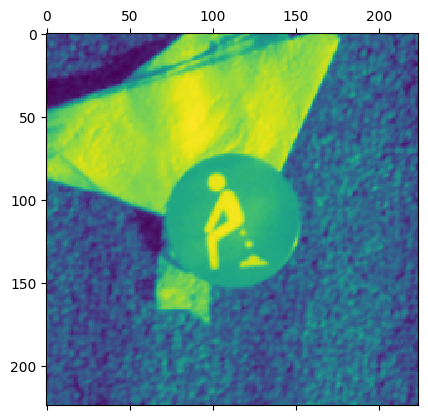

In [ ]:
distort = F.grid_sample(input_tensor[0:1], diffeo_grids.to(device), align_corners=True)
undistort = F.grid_sample(distort, inv_diffeo_grids.to(device), align_corners=True)
plt.matshow(undistort[0,0].cpu())

# Experiment

## Get Latent Layers

In [11]:
from utils.get_model_activation import retrieve_layer_activation, get_flatten_children

In [12]:
layer_id = [2,8,13]

activations, _ = retrieve_layer_activation(model, input_tensor, layer_id)

distort_input = F.grid_sample(input_tensor, diffeo_grids.to(device).expand(100,-1,-1,-1), align_corners=True)
dist_act, _ = retrieve_layer_activation(model, distort_input, layer_id)

In [13]:
dist_act[2].shape

torch.Size([100, 197, 768])

## Regression Model 

In [14]:
class Autoencoder(nn.Module):
  def __init__(self, flow_grid, dtype=torch.float32):
    super(Autoencoder, self).__init__()

    # Parameters for model
    self.flow_grid = flow_grid
    input_size = 197 * 768
    self.image_length = 64
    self.compression_size = self.image_length**2 * 3

    # Model
    self.encoder = nn.Sequential(
        nn.Linear(input_size, self.compression_size),
    )
    self.decoder = nn.Sequential(
        nn.Linear(self.compression_size, input_size),
    )
    self.to(dtype)

  def forward(self, x):
    B, W, C = x.shape # batch, number of words, channel
    
    # Encoder
    x = nn.Flatten(x)
    x = self.encoder(x)

    # g^{-1}_{naive}
    x = x.reshape(B, 3, self.image_length, self.image_length) # b&w image
    flow_grid_expanded = self.flow_grid.expand(batch_size, -1, -1, -1)  # Expand to match batch size
    x = F.grid_sample(x, flow_grid_expanded, align_corners=True)
    x = x.reshape(B, -1)

    # Decoder
    x = self.decoder(x)
    x = x.reshape(B, W, C)
    return x

## Train

In [15]:
# Model
flow_gridInverse = inv_diffeo_grids.to(device)

autoencoder = Autoencoder(flow_grid=flow_gridInverse)
autoencoder.to(device)

trainable_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

: 

In [17]:
criterion = nn.MSELoss()  # Example loss function

X = diffeo_activation.view(diffeo_activation.size(0), -1).to(dtype)
y = original_activation.view(original_activation.size(0), -1).to(dtype)

print('Baseline', float(criterion(X,y)))

Baseline 0.7234963178634644


In [18]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 1

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [22]:
def gradient_norm(model, norm_type=2):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.norm(norm_type)
            total_norm += param_norm.item() ** norm_type
    return total_norm ** (1.0 / norm_type)  # Compute the final norm

In [34]:
optimizer = optim.SGD(autoencoder.parameters(), lr=1e-6)

epochs = 1000
for epoch in tqdm(range(epochs)):
    model.train()
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = autoencoder(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    grad_norm = gradient_norm(model)
    print('Grad Norm', grad_norm)
    print('Loss', loss.item())  # Ensure you print the scalar value

  0%|          | 0/1000 [00:00<?, ?it/s]

Grad Norm 0.0


  0%|          | 1/1000 [00:03<55:08,  3.31s/it]

Loss 0.8281074166297913
Grad Norm 0.0


  0%|          | 2/1000 [00:06<55:04,  3.31s/it]

Loss 0.8985432386398315
Grad Norm 0.0


  0%|          | 3/1000 [00:09<55:00,  3.31s/it]

Loss 0.893784761428833
Grad Norm 0.0


  0%|          | 4/1000 [00:13<54:57,  3.31s/it]

Loss 0.7708393931388855
Grad Norm 0.0


  0%|          | 5/1000 [00:16<54:54,  3.31s/it]

Loss 0.9064025282859802
Grad Norm 0.0


  1%|          | 6/1000 [00:19<54:50,  3.31s/it]

Loss 0.827397882938385
Grad Norm 0.0


  1%|          | 7/1000 [00:23<54:47,  3.31s/it]

Loss 0.9308109283447266
Grad Norm 0.0


  1%|          | 8/1000 [00:26<54:44,  3.31s/it]

Loss 0.9064022898674011
Grad Norm 0.0


  1%|          | 9/1000 [00:29<54:40,  3.31s/it]

Loss 0.881846010684967
Grad Norm 0.0


  1%|          | 10/1000 [00:33<54:37,  3.31s/it]

Loss 0.7935891151428223
Grad Norm 0.0


  1%|          | 11/1000 [00:36<54:34,  3.31s/it]

Loss 0.9348646998405457
Grad Norm 0.0


  1%|          | 12/1000 [00:39<54:30,  3.31s/it]

Loss 0.9740312099456787
Grad Norm 0.0


  1%|▏         | 13/1000 [00:43<54:27,  3.31s/it]

Loss 0.8985424041748047
Grad Norm 0.0


  1%|▏         | 14/1000 [00:46<54:24,  3.31s/it]

Loss 0.9154112339019775
Grad Norm 0.0


  2%|▏         | 15/1000 [00:49<54:21,  3.31s/it]

Loss 0.8001551628112793
Grad Norm 0.0


  2%|▏         | 16/1000 [00:52<54:17,  3.31s/it]

Loss 0.7958672046661377
Grad Norm 0.0


  2%|▏         | 17/1000 [00:56<54:14,  3.31s/it]

Loss 0.9154110550880432
Grad Norm 0.0


  2%|▏         | 18/1000 [00:59<54:11,  3.31s/it]

Loss 0.887718915939331
Grad Norm 0.0


  2%|▏         | 19/1000 [01:02<54:07,  3.31s/it]

Loss 0.752263069152832
Grad Norm 0.0


  2%|▏         | 20/1000 [01:06<54:04,  3.31s/it]

Loss 0.8649892807006836
Grad Norm 0.0


  2%|▏         | 21/1000 [01:09<54:01,  3.31s/it]

Loss 0.8588055968284607
Grad Norm 0.0


  2%|▏         | 22/1000 [01:12<53:57,  3.31s/it]

Loss 0.8194716572761536
Grad Norm 0.0


  2%|▏         | 23/1000 [01:16<53:54,  3.31s/it]

Loss 0.736542284488678
Grad Norm 0.0


  2%|▏         | 24/1000 [01:19<53:51,  3.31s/it]

Loss 0.8877185583114624
Grad Norm 0.0


  2%|▎         | 25/1000 [01:22<53:47,  3.31s/it]

Loss 0.8145715594291687
Grad Norm 0.0


  3%|▎         | 26/1000 [01:26<53:44,  3.31s/it]

Loss 1.0025583505630493
Grad Norm 0.0


  3%|▎         | 27/1000 [01:29<53:41,  3.31s/it]

Loss 0.815471351146698
Grad Norm 0.0


  3%|▎         | 28/1000 [01:32<53:37,  3.31s/it]

Loss 0.8144868612289429
Grad Norm 0.0


  3%|▎         | 29/1000 [01:36<53:34,  3.31s/it]

Loss 0.7837644815444946
Grad Norm 0.0


  3%|▎         | 30/1000 [01:39<53:31,  3.31s/it]

Loss 0.9060075879096985
Grad Norm 0.0


  3%|▎         | 31/1000 [01:42<53:28,  3.31s/it]

Loss 0.7708376049995422
Grad Norm 0.0


  3%|▎         | 32/1000 [01:45<53:24,  3.31s/it]

Loss 0.8118466138839722
Grad Norm 0.0


  3%|▎         | 33/1000 [01:49<53:21,  3.31s/it]

Loss 0.7758515477180481
Grad Norm 0.0


  3%|▎         | 34/1000 [01:52<53:18,  3.31s/it]

Loss 0.8194708228111267
Grad Norm 0.0


  4%|▎         | 35/1000 [01:55<53:14,  3.31s/it]

Loss 0.9642014503479004
Grad Norm 0.0


  4%|▎         | 36/1000 [01:59<53:11,  3.31s/it]

Loss 0.8593108654022217
Grad Norm 0.0


  4%|▎         | 37/1000 [02:02<53:08,  3.31s/it]

Loss 0.8196184635162354
Grad Norm 0.0


  4%|▍         | 38/1000 [02:05<53:04,  3.31s/it]

Loss 0.7944662570953369
Grad Norm 0.0


  4%|▍         | 39/1000 [02:09<53:01,  3.31s/it]

Loss 0.9195939302444458
Grad Norm 0.0


  4%|▍         | 40/1000 [02:12<52:58,  3.31s/it]

Loss 0.7522618770599365
Grad Norm 0.0


  4%|▍         | 41/1000 [02:15<52:55,  3.31s/it]

Loss 0.7365411520004272
Grad Norm 0.0


  4%|▍         | 42/1000 [02:19<52:51,  3.31s/it]

Loss 0.9187865853309631
Grad Norm 0.0


  4%|▍         | 43/1000 [02:22<52:48,  3.31s/it]

Loss 0.9068804979324341
Grad Norm 0.0


  4%|▍         | 44/1000 [02:25<52:45,  3.31s/it]

Loss 0.9154089689254761
Grad Norm 0.0


  4%|▍         | 45/1000 [02:28<52:41,  3.31s/it]

Loss 0.8721728324890137
Grad Norm 0.0


  5%|▍         | 46/1000 [02:32<52:38,  3.31s/it]

Loss 0.9028838276863098
Grad Norm 0.0


  5%|▍         | 47/1000 [02:35<52:35,  3.31s/it]

Loss 0.9009443521499634
Grad Norm 0.0


  5%|▍         | 48/1000 [02:38<52:31,  3.31s/it]

Loss 0.8588669896125793
Grad Norm 0.0


  5%|▍         | 49/1000 [02:42<52:28,  3.31s/it]

Loss 0.8842207193374634
Grad Norm 0.0


  5%|▌         | 50/1000 [02:45<52:25,  3.31s/it]

Loss 0.8782820701599121
Grad Norm 0.0


  5%|▌         | 51/1000 [02:48<52:21,  3.31s/it]

Loss 0.9308078289031982
Grad Norm 0.0


  5%|▌         | 52/1000 [02:52<52:18,  3.31s/it]

Loss 0.7708362340927124
Grad Norm 0.0


  5%|▌         | 53/1000 [02:55<52:15,  3.31s/it]

Loss 0.7708361744880676
Grad Norm 0.0


  5%|▌         | 54/1000 [02:58<52:11,  3.31s/it]

Loss 0.81157386302948
Grad Norm 0.0


  6%|▌         | 55/1000 [03:02<52:08,  3.31s/it]

Loss 0.8509038090705872
Grad Norm 0.0


  6%|▌         | 56/1000 [03:05<52:05,  3.31s/it]

Loss 0.8614981770515442
Grad Norm 0.0


  6%|▌         | 57/1000 [03:08<52:02,  3.31s/it]

Loss 0.9686716794967651
Grad Norm 0.0


  6%|▌         | 58/1000 [03:12<51:58,  3.31s/it]

Loss 0.8812851309776306
Grad Norm 0.0


  6%|▌         | 59/1000 [03:15<51:58,  3.31s/it]

Loss 0.8812850713729858


KeyboardInterrupt: 